In [6]:
import h_transport_materials as htm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from analysis_functions import parse_ufloat
from uncertainties import unumpy as unp

In [7]:
# material_str = "316l_steel"
material_str = "fresh_steel"

# filter only 316l_steel and H
diffusivities = htm.diffusivities.filter(material=material_str).filter(isotope="h")
permeabilities = htm.permeabilities.filter(material=material_str).filter(isotope="h")

/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/h_transport_materials/properties_group.py:81: UserWarning: No property matching the requirements
  warnings.warn("No property matching the requirements")
/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/h_transport_materials/properties_group.py:81: UserWarning: No property matching the requirements
  warnings.warn("No property matching the requirements")
/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/h_transport_materials/properties_group.py:81: UserWarning: No property matching the requirements
  warnings.warn("No property matching the requirements")
/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/h_transport_materials/properties_group.py:81: UserWarning: No property matching the requirements
  warnings.warn("No property matching the requirements")


In [8]:
# --- Edit this path ---
csv_path = f"results/figs/{material_str}_diffusivities.csv"

# --- Read and clean data ---
df = pd.read_csv(csv_path)

# Apply parser to relevant columns
for col in ["Temperature (K)", "Diffusivity", "Permeability", "Flux"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_ufloat)

# Drop rows with missing data
df = df.dropna(subset=["Temperature (K)", "Diffusivity", "Permeability"])

# Sort by the nominal value of Temperature
df = df.sort_values(by="Temperature (K)", key=lambda s: [v.n if hasattr(v, "n") else v for v in s])

# Extract numeric arrays or ufloats
T = df["Temperature (K)"].to_numpy()
D = df["Diffusivity"].to_numpy()
Phi = df["Permeability"].to_numpy()
P_up = df["Upstream Pressure (Torr)"].to_numpy()
Flux = df["Flux"].to_numpy() if "Flux" in df.columns else None

# get nominal and std arrays for plotting
T_nom = [t.n if hasattr(t, "n") else t for t in T]
D_nom = [d.n if hasattr(d, "n") else d for d in D]
Phi_nom = [p.n if hasattr(p, "n") else p for p in Phi]
D_std = [d.s if hasattr(d, "s") else 0 for d in D]
Phi_std = [p.s if hasattr(p, "s") else 0 for p in Phi]

if Flux is not None:
    Flux_nom = np.array([f.n if hasattr(f, "n") else f for f in Flux])
    Flux_std = np.array([f.s if hasattr(f, "s") else 0 for f in Flux])

[492.1628315  493.57261954 494.11472513 494.93658012]


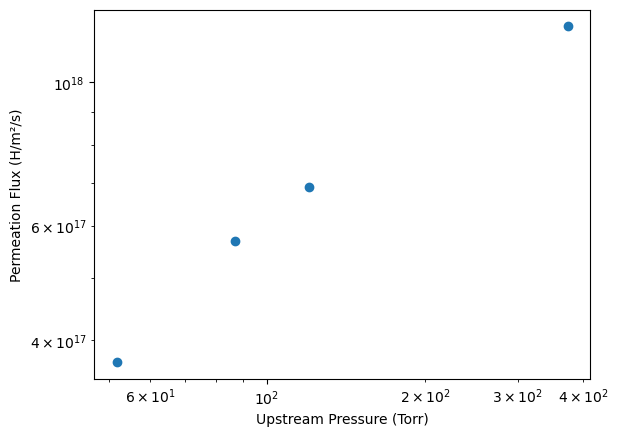

In [9]:
T = 490
dT = 20
low = T - dT
high = T + dT


T_nom = np.array(T_nom)
P_up = np.array(P_up)
Phi_nom = np.array(Phi_nom)

valid_T_nom = (T_nom >= low) & (T_nom <= high)
idx = np.where(valid_T_nom)[0]

print(T_nom[idx])

plt.figure()
plt.loglog(P_up[idx], Flux_nom[idx], 'o')
plt.ylabel("Permeation Flux (H/m²/s)")
plt.xlabel("Upstream Pressure (Torr)")
plt.show()

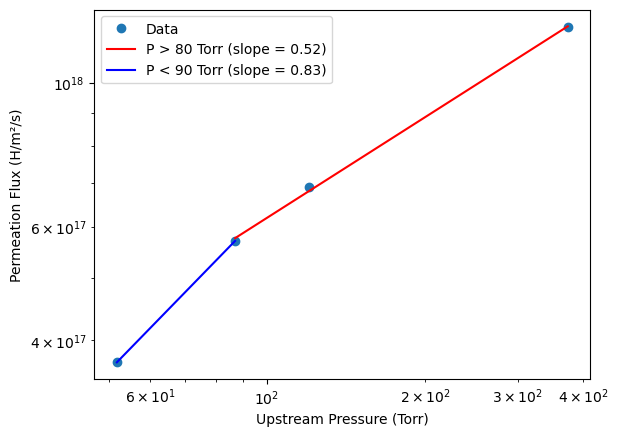

In [10]:
# Filter points above 50 torr for slope calculation
high_pressure_mask = P_up[idx] > 80
P_high = P_up[idx][high_pressure_mask]
Flux_high = Flux_nom[idx][high_pressure_mask]

# Fit a line in log-log space: log(Flux) = slope * log(P) + intercept
log_P_high = np.log10(P_high)
log_Flux_high = np.log10(Flux_high)
slope_high, intercept_high = np.polyfit(log_P_high, log_Flux_high, 1)

# Generate fit line for high pressure
P_fit_high = np.logspace(np.log10(P_high.min()), np.log10(P_high.max()), 60)
Flux_fit_high = 10**(slope_high * np.log10(P_fit_high) + intercept_high)

# Filter points below 100 torr for slope calculation
low_pressure_mask = P_up[idx] < 90
P_low = P_up[idx][low_pressure_mask]
Flux_low = Flux_nom[idx][low_pressure_mask]

# Fit a line in log-log space for low pressure
log_P_low = np.log10(P_low)
log_Flux_low = np.log10(Flux_low)
slope_low, intercept_low = np.polyfit(log_P_low, log_Flux_low, 1)

# Generate fit line for low pressure
P_fit_low = np.logspace(np.log10(P_low.min()), np.log10(P_low.max()), 60)
Flux_fit_low = 10**(slope_low * np.log10(P_fit_low) + intercept_low)

plt.figure()
plt.loglog(P_up[idx], Flux_nom[idx], 'o', label='Data')
plt.loglog(P_fit_high, Flux_fit_high, 'r-', label=f'P > 80 Torr (slope = {slope_high:.2f})')
plt.loglog(P_fit_low, Flux_fit_low, 'b-', label=f'P < 90 Torr (slope = {slope_low:.2f})')
plt.ylabel("Permeation Flux (H/m²/s)")
plt.xlabel("Upstream Pressure (Torr)")
plt.legend()
plt.show()